In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from datetime import date
import tkinter.messagebox as mbox

from bs4 import BeautifulSoup
import time
from selenium import webdriver
from urllib.parse import urljoin

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""
    ##### Web scrapper for infinite scrolling page #####
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if i == 20:
            break 

    ##### Extract Reddit URLs #####
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup

In [3]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [4]:
def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    news_source = news_tag.find_all('span')[0].text #source
    news_time = news_tag.find_all('span')[1].text #link
    news_headline = news_tag.find('a').text #heading
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'time' : news_time,    
            'headline' : news_headline,
            'content' : news_content,
           }

In [5]:
def scrape_yahoo_news(url, path=None):
    """Get the yahoo finance market news and write them to CSV file """
    if path is None:
        path = 'stock-market-news.csv'
        
    #print('Requesting html page')
    doc = get_page(url)

    #print('Extracting news tags')
    news_list = get_news_tags(doc)

    #print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    #print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    #news_df.to_csv(path, index=None)
    
    #This return statement is optional, we are doing this just analyze the final output 
    return news_df 

In [6]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [7]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

from transformers import pipeline

In [8]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Ticker

In [9]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [10]:
text_input = input("Type in the Ticker: ")
print("You entered:", text_input)

#text_input = 'xom'

You entered: xom


# Yahoo Finance News

In [11]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Report Date = ", date.today())
print("Report Time =", current_time)
YAHOO_NEWS_URL = f'https://finance.yahoo.com/quote/{text_input}?p={text_input}&.tsrc=fin-srch'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Report Date =  2023-04-13
Report Time = 08:17:08


In [13]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [14]:
#news_df[news_df['Score'] > 0.8] 
news_df2 = news_df[news_df['Score'] > 0.8] [news_df[news_df['Score'] > 0.8] ['Score2'] > 0.8]

In [21]:
news_df2.head(20)

,source,time,headline,content,Sentiment,Score,Sentiment2,Score2
0,Insider Monkey,21 hours ago,11 Best Undervalued Energy Stocks to Buy According to Analysts,"In this article, we will discuss the 11 best undervalued energy stocks to buy according to analysts. If you want to explore similar stocks, you can also take a look at 5 Best Undervalued Energy Stocks to Buy According to Analysts. “It’s Obviously A Positive For The Energy Sector” On April 2, OPEC+ announced an […]",POSITIVE,0.998835,POSITIVE,0.999089
1,TheStreet.com,21 hours ago,"With the Oil Patch Facing Consolidation, One Stock Stands Out","Energy giants are investing on finding ways to contribute to the still developing global transition to a green energy future, and they'd like to remain permanently relevant.",POSITIVE,0.998394,POSITIVE,0.999688
2,Zacks,22 hours ago,ExxonMobil's (XOM) Prosperity FPSO Reaches Guyana Stabroek Block,The Prosperity vessel will be permitted to ExxonMobil (XOM) to operate on the Payara project offshore Guyana.,NEGATIVE,0.990843,NEGATIVE,0.936813
3,Insider Monkey,yesterday,12 Best Energy Stocks To Invest In According to Analysts,"In this article, we will take a look at the 12 best energy stocks to invest in according to analysts. If you want to explore similar stocks, you can also take a look at 5 Best Energy Stocks To Invest In According to Analysts. On April 7, the Wall Street Journal reported that oil giant Exxon Mobil […]",POSITIVE,0.999674,POSITIVE,0.995061
5,The Wall Street Journal,2 days ago,Biggest Gains in Innovation in the Management Top 250,"Exxon Mobil score for innovation rose more than that of any other company in the latest Management Top 250, followed by Allstate and Crown Castle. The Management Top 250 ranking, developed by the Drucker Institute, measures corporate effectiveness by examining performance in customer satisfaction, employee engagement and development, innovation, social responsibility and financial strength. The innovation scores of Allstate and Crown Castle both jumped 31.5 points, to 105.3 and 76.7, r...",POSITIVE,0.999655,POSITIVE,0.973598
7,Zacks,2 days ago,Oil & Gas Stock Roundup: Q1 Updates From ExxonMobil and Shell in Focus,"Apart from ExxonMobil (XOM) and Shell (SHEL), Ovintiv (OVV), Halliburton (HAL) and Enbridge (ENB) hogged attention during the week.",NEGATIVE,0.895621,POSITIVE,0.959791
10,The Wall Street Journal,2 days ago,Exxon Deal Hunt Signals Possible Shale M&A Wave,A transaction involving Pioneer Natural Resources would indicate that drillers are looking to put their large war chests of cash to work.,NEGATIVE,0.992457,NEGATIVE,0.996657
11,Zacks,3 days ago,Markets Flat (Russell +1%) with Econ Data Pending,What we see here in a flat trading day is market participants biding their time before the next potential market catalyst.,NEGATIVE,0.999744,NEGATIVE,0.999530
12,Zacks,3 days ago,Exxon Mobil (XOM) Stock Sinks As Market Gains: What You Should Know,"Exxon Mobil (XOM) closed the most recent trading day at $114.54, moving -0.44% from the previous trading session.",NEGATIVE,0.999705,NEGATIVE,0.971162
13,Fox Business,3 days ago,"Exxon Mobil, Pioneer rumors spark fracking M&A talk",Exxon Mobil is reportedly in preliminary discussions to acquire Pioneer Natural Resources as part of the oil and natural gas producer’s Permian Basin strategy.,NEGATIVE,0.989955,NEGATIVE,0.830148


In [22]:
text_input2 = input("How many rows of news?: ")
text_input2 = int(text_input2)

# Sentiment

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

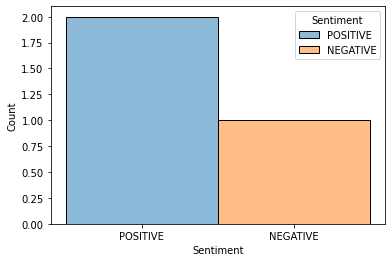

In [23]:
sns.histplot(x = 'Sentiment', data = news_df2[:text_input2], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

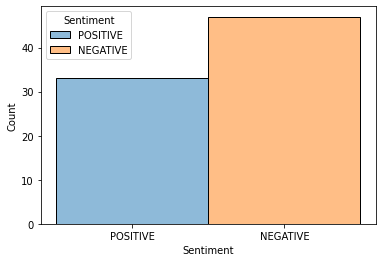

In [24]:
sns.histplot(x = 'Sentiment', data = news_df2, hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

# Headline Trigram

In [25]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["headline"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Content Trigram

In [26]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["content"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Finviz

In [27]:
url = f"https://finviz.com/quote.ashx?t={text_input}&ty=c&ta=1&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [28]:
df = pd.DataFrame(sentence2)

In [29]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [30]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i

In [31]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score

In [32]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

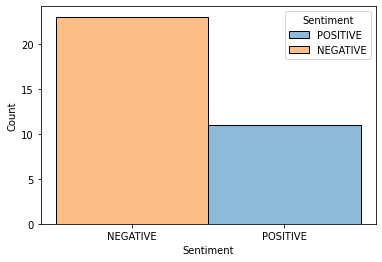

In [33]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

In [64]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in df["Headline_Lower"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

KeyError: 'Headline_Lower'

# Forecast

In [65]:
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=1095), end=dt.date.today())
df=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [66]:
start_time = pd.Timestamp(df['Date'][0])
end_time = pd.Timestamp(df['Date'][len(df)-1])
time_range = pd.date_range(start_time, end_time, freq=df['Date'][1] - df['Date'][0] )

time_list = time_range.tolist()


time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Date'])
df_dates['Date'] = time_list

#Ensure all reading time exists, fill with 0 for missing reading times
df = pd.merge(df, df_dates, on='Date', how='right')

df.fillna(method='ffill', inplace=True)

In [67]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Date', y = 'Close', data = df)
# plt.show()

In [68]:
# Load SPY price data
spy_data = df
spy_data = df[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=365, include_history=False)

# Make predictions for future dates
forecast = model.predict(future_dates)

08:25:43 - cmdstanpy - INFO - Chain [1] start processing
08:25:44 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

# One Year Outlook

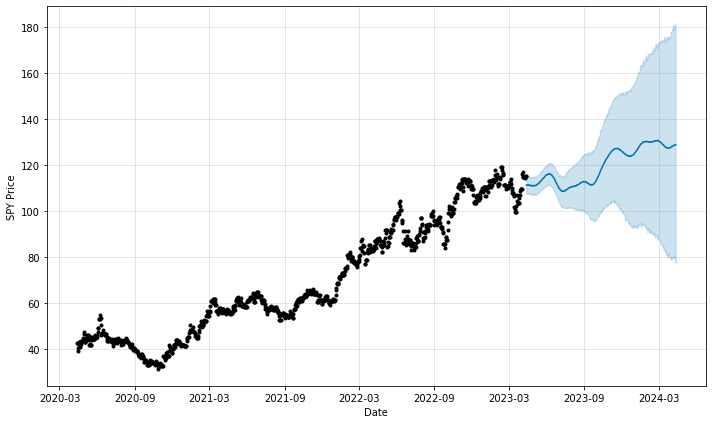

(19095.0, 19825.0)

(117.24302806574978, 122.02845778271917)

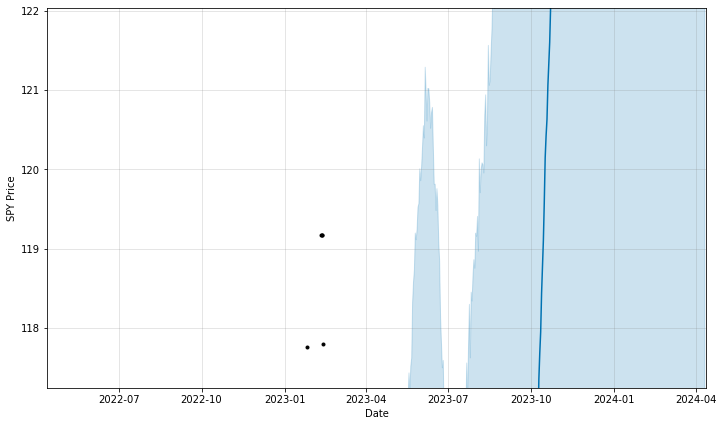

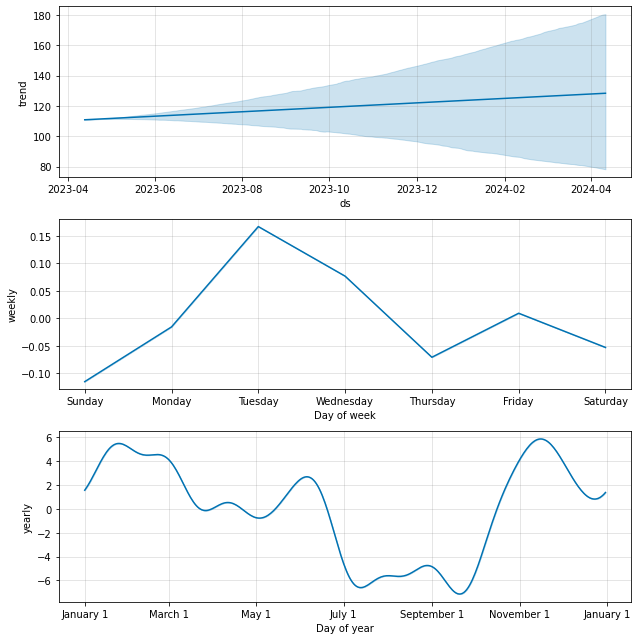

In [70]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=365), dt.date.today() + dt.timedelta(days=365))
plt.ylim(forecast['yhat'].mean()*0.9, forecast['yhat'].mean()*1.1)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [71]:
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=30), end=dt.date.today())
df1=spy_ohlc_df.reset_index()

# spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today())
# df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [72]:
start_time = pd.Timestamp(df1['Date'][0])
end_time = pd.Timestamp(df1['Date'][len(df1)-1])
time_range = pd.date_range(start_time, end_time, freq=df1['Date'][1] - df1['Date'][0] )

time_list = time_range.tolist()


time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Date'])
df_dates['Date'] = time_list

#Ensure all reading time exists, fill with 0 for missing reading times
df1 = pd.merge(df1, df_dates, on='Date', how='right')

df1.fillna(method='ffill', inplace=True)

In [73]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
# plt.show()

In [74]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Date', 'Close']]
#spy_data = df1[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=30, include_history=False)

# Make predictions for future dates
forecast = model.predict(future_dates)


08:25:47 - cmdstanpy - INFO - Chain [1] start processing
08:25:47 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

# 10 Days Outlook

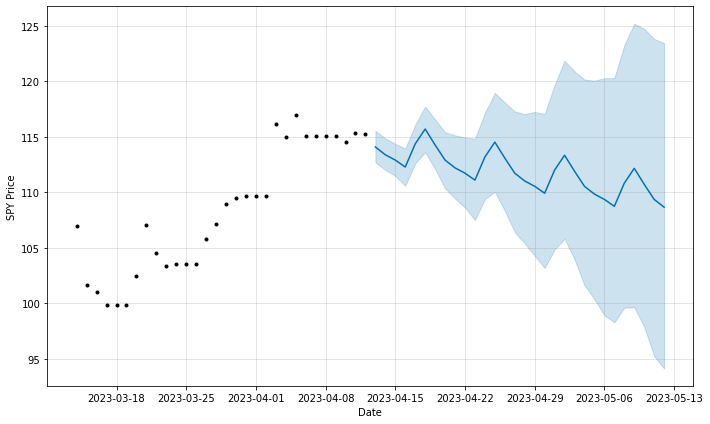

(19450.0, 19470.0)

(109.65298583157532, 114.1286179063335)

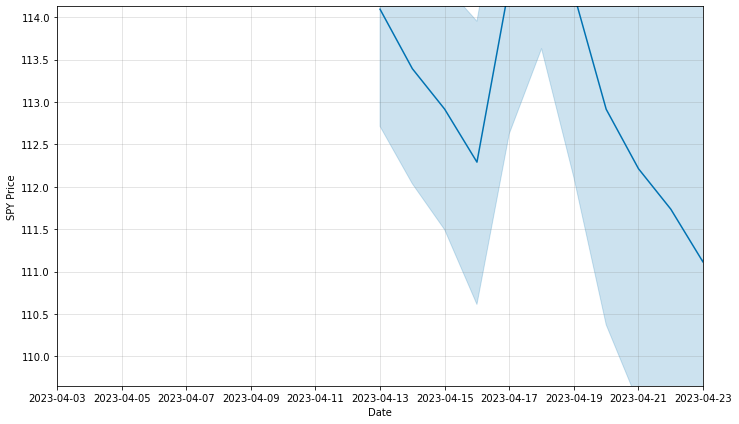

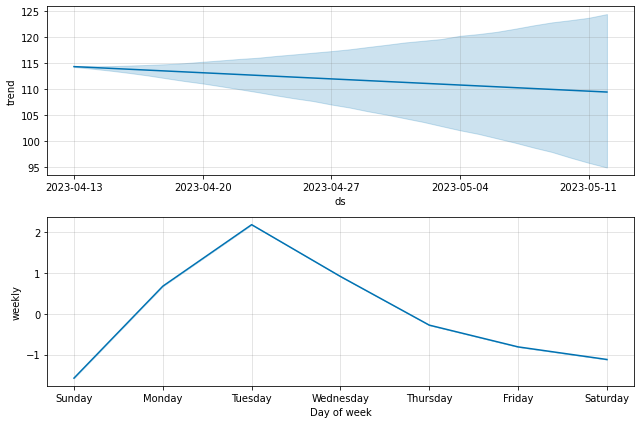

In [76]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=10), dt.date.today() + dt.timedelta(days=10))
plt.ylim(forecast['yhat'].mean()*0.9, forecast['yhat'].mean()*1.1)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [77]:
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today(), interval='1m')
df1=spy_ohlc_df.reset_index()

# spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today())
# df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [78]:
start_time = pd.Timestamp(df1['Datetime'][0])
end_time = pd.Timestamp(df1['Datetime'][len(df1)-1])
time_range = pd.date_range(start_time, end_time, freq=df1['Datetime'][1] - df1['Datetime'][0] )

time_list = time_range.tolist()

In [79]:
time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Datetime'])
df_dates['Datetime'] = time_list

In [80]:
#Ensure all reading time exists, fill with 0 for missing reading times
df1 = pd.merge(df1, df_dates, on='Datetime', how='right')

In [81]:
df1.fillna(method='ffill', inplace=True)

In [82]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
# plt.show()

In [83]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Datetime', 'Close']]
#spy_data = df1[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=2880, freq='T', include_history=False)


# Make predictions for future dates
forecast = model.predict(future_dates)


08:25:50 - cmdstanpy - INFO - Chain [1] start processing
08:26:00 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

# One Day Outlook

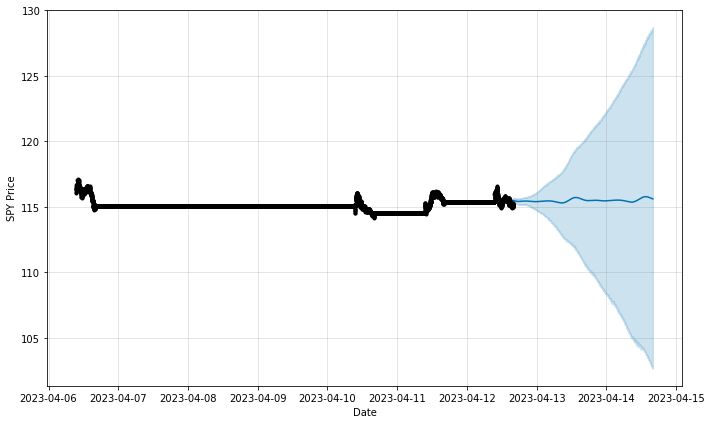

(19459.0, 19461.0)

(113.18248810796332, 117.80218150012509)

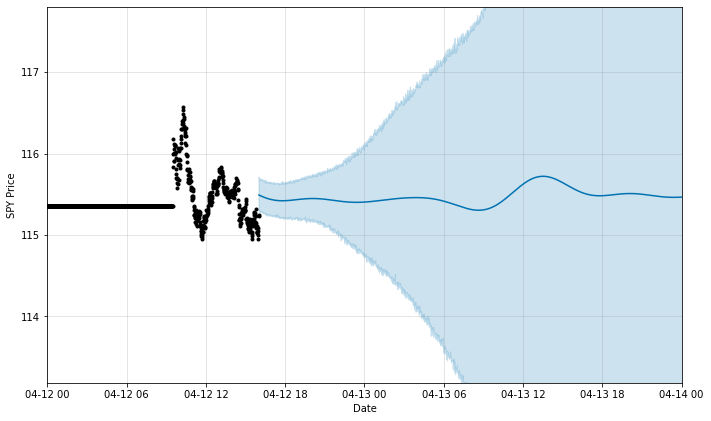

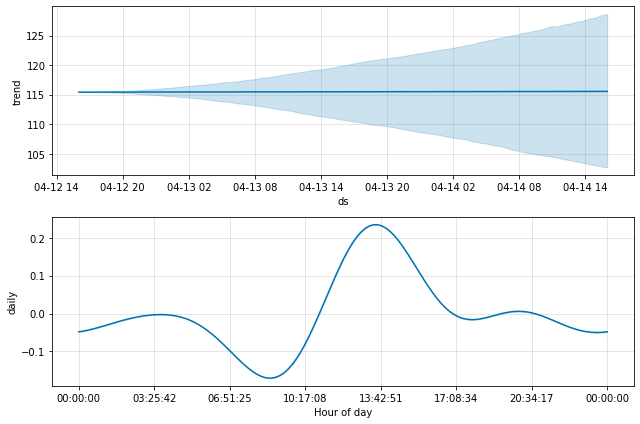

In [85]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=1), dt.date.today() + dt.timedelta(minutes=1440))
plt.ylim(forecast['yhat'].mean()*0.98, forecast['yhat'].mean()*1.02)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()